# SPICE Netlist Parser

This notebook demonstrates Pulsim's SPICE-like netlist parser for creating circuits from text descriptions.

## Contents
1. Basic SPICE Syntax
2. Engineering Suffixes
3. Linear Devices (R, L, C, V, I)
4. Nonlinear Devices (D, S, M, Q)
5. Model Definitions
6. Complete Examples
7. Error Handling

In [1]:
import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

print(f"Pulsim version: {ps.__version__}")
print(f"\nParser functions available:")
print(f"  parse_netlist: {hasattr(ps, 'parse_netlist')}")
print(f"  parse_netlist_verbose: {hasattr(ps, 'parse_netlist_verbose')}")
print(f"  parse_value: {hasattr(ps, 'parse_value')}")

Pulsim version: 2.0.0

Parser functions available:
  parse_netlist: True
  parse_netlist_verbose: True
  parse_value: True


## 1. Basic SPICE Syntax

SPICE netlists use a simple line-based format:

```spice
* Title/comment (first line)
Rname n1 n2 value      ; Resistor
Cname n1 n2 value      ; Capacitor
Lname n1 n2 value      ; Inductor
Vname n+ n- value      ; Voltage source
Iname n+ n- value      ; Current source
Dname anode cathode    ; Diode
Sname n1 n2 [ON|OFF]   ; Switch
Mname d g s [model]    ; MOSFET
Qname c g e [model]    ; IGBT
.MODEL name type (params)
.end
```

Ground node aliases: `0`, `gnd`, `GND`, `ground`

In [2]:
# Simple voltage divider
netlist = """
* Voltage Divider
V1 in 0 10
R1 in out 1k
R2 out 0 1k
.end
"""

ckt = ps.parse_netlist(netlist)
print(f"Circuit: {ckt.num_devices()} devices, {ckt.num_nodes()} nodes")

# DC analysis
opts = ps.NewtonOptions()
x0 = np.zeros(ckt.system_size())
dc = ps.solve_dc(ckt, x0, opts)

print(f"DC converged: {dc.success()}")
print(f"\nVoltages:")
print(f"  v_in  = {dc.solution[0]:.2f} V")
print(f"  v_out = {dc.solution[1]:.2f} V (expected 5V)")

Circuit: 3 devices, 2 nodes
DC converged: True

Voltages:
  v_in  = 10.00 V
  v_out = 5.00 V (expected 5V)


## 2. Engineering Suffixes

The parser supports standard engineering suffixes:

| Suffix | Multiplier | Example |
|--------|------------|----------|
| f | 10⁻¹⁵ | 100f = 100 fF |
| p | 10⁻¹² | 10p = 10 pF |
| n | 10⁻⁹ | 100n = 100 nF |
| u | 10⁻⁶ | 1u = 1 µF |
| m | 10⁻³ | 10m = 10 mΩ |
| k | 10³ | 10k = 10 kΩ |
| meg | 10⁶ | 1meg = 1 MΩ |
| g | 10⁹ | 1g = 1 GΩ |

In [3]:
# Test parse_value function
test_values = ['100', '10k', '1.5meg', '100u', '4.7n', '1e-6', '2.2m']

print("Engineering suffix parsing:")
for v in test_values:
    result = ps.parse_value(v)
    print(f"  '{v}' -> {result:.6g}")

Engineering suffix parsing:
  '100' -> 100
  '10k' -> 10000
  '1.5meg' -> 1.5e+06
  '100u' -> 0.0001
  '4.7n' -> 4.7e-09
  '1e-6' -> 1e-06
  '2.2m' -> 0.0022


## 3. Linear Devices

### Resistor, Capacitor, Inductor
```spice
Rname n1 n2 value
Cname n1 n2 value [IC=initial_voltage]
Lname n1 n2 value [IC=initial_current]
```

### Voltage and Current Sources
```spice
Vname n+ n- value
Vname n+ n- DC value
Iname n+ n- value
```

RC Circuit: 3 devices


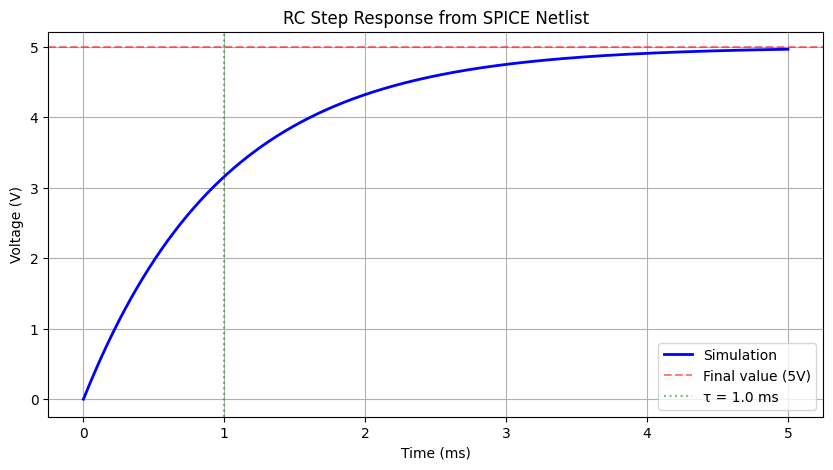

Final v_out: 4.9663 V (expected ~5V)


In [4]:
# RC circuit with initial condition
rc_netlist = """
* RC Step Response
V1 in 0 5
R1 in out 1k
C1 out 0 1u IC=0
.end
"""

ckt = ps.parse_netlist(rc_netlist)
print(f"RC Circuit: {ckt.num_devices()} devices")

# Transient simulation (5 time constants = 5ms for tau = 1ms)
x0 = np.zeros(ckt.system_size())
times, states, success, msg = ps.run_transient(ckt, 0.0, 5e-3, 1e-6, x0)

states = np.array(states)
tau = 1e3 * 1e-6  # R * C = 1ms

plt.figure(figsize=(10, 5))
plt.plot(np.array(times) * 1000, states[:, 1], 'b-', linewidth=2, label='Simulation')
plt.axhline(y=5.0, color='r', linestyle='--', alpha=0.5, label='Final value (5V)')
plt.axvline(x=tau*1000, color='g', linestyle=':', alpha=0.5, label=f'τ = {tau*1000:.1f} ms')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('RC Step Response from SPICE Netlist')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final v_out: {states[-1, 1]:.4f} V (expected ~5V)")

RLC Circuit: 4 devices, 3 nodes

Resonant frequency: 1591.5 Hz
Quality factor Q: 1.00


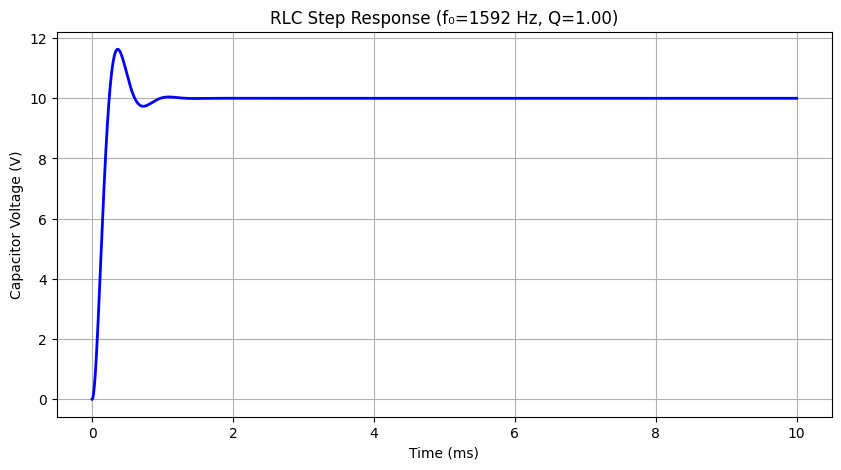

In [5]:
# RLC circuit
rlc_netlist = """
* Series RLC Circuit
V1 in 0 10
R1 in n1 100
L1 n1 n2 10m IC=0
C1 n2 0 1u IC=0
.end
"""

ckt = ps.parse_netlist(rlc_netlist)
print(f"RLC Circuit: {ckt.num_devices()} devices, {ckt.num_nodes()} nodes")

# Calculate resonant frequency
L = 10e-3
C = 1e-6
R = 100
f0 = 1 / (2 * np.pi * np.sqrt(L * C))
Q = (1/R) * np.sqrt(L/C)
print(f"\nResonant frequency: {f0:.1f} Hz")
print(f"Quality factor Q: {Q:.2f}")

# Transient simulation
x0 = np.zeros(ckt.system_size())
times, states, success, msg = ps.run_transient(ckt, 0.0, 10e-3, 1e-6, x0)
states = np.array(states)

plt.figure(figsize=(10, 5))
plt.plot(np.array(times) * 1000, states[:, 2], 'b-', linewidth=2)  # Voltage across C
plt.xlabel('Time (ms)')
plt.ylabel('Capacitor Voltage (V)')
plt.title(f'RLC Step Response (f₀={f0:.0f} Hz, Q={Q:.2f})')
plt.grid(True)
plt.show()

## 4. Nonlinear Devices

### Diode
```spice
Dname anode cathode [model]
```

### Switch
```spice
Sname n1 n2 [ON|OFF] [model]
```

### MOSFET
```spice
Mname drain gate source [model]
```

### IGBT
```spice
Qname collector gate emitter [model]
```

In [6]:
# Half-wave rectifier with diode
rectifier_netlist = """
* Half-Wave Rectifier
V1 ac_in 0 10
D1 ac_in dc_out
R1 dc_out 0 1k
.end
"""

ckt = ps.parse_netlist(rectifier_netlist)
print(f"Rectifier: {ckt.num_devices()} devices")

# DC analysis
result = ps.dc_operating_point(ckt)
print(f"DC converged: {result.success}")
if result.success:
    print(f"\nWith 10V DC input:")
    print(f"  v_ac_in = {result.newton_result.solution[0]:.2f} V")
    print(f"  v_dc_out = {result.newton_result.solution[1]:.2f} V")

Rectifier: 3 devices
DC converged: True

With 10V DC input:
  v_ac_in = 10.00 V
  v_dc_out = 10.00 V


In [7]:
# Buck converter with switch and diode
buck_netlist = """
* Simplified Buck Converter
Vin input 0 48
S1 input sw_node ON
D1 0 sw_node
L1 sw_node output 100u
C1 output 0 100u
Rload output 0 2.4
.end
"""

result = ps.parse_netlist_verbose(buck_netlist)
print(f"Title: {result.title}")
print(f"Nodes: {result.node_map}")
print(f"Devices: {result.circuit.num_devices()}")
print(f"Warnings: {len(result.warnings)}")

Title: Simplified Buck Converter
Nodes: {'input': 0, 'output': 1, 'sw_node': 2}
Devices: 6
Warnings: 0


## 5. Model Definitions

Use `.MODEL` to define device parameters:

```spice
.MODEL name NMOS (VTH=2 KP=0.5 LAMBDA=0.01)
.MODEL name PMOS (VTH=-1.5 KP=0.3)
.MODEL name IGBT (VTH=5 GON=1e4 GOFF=1e-12 VCESAT=1.5)
```

In [8]:
# MOSFET with model
mosfet_netlist = """
* MOSFET Amplifier
Vdd drain 0 12
Vg gate 0 5
M1 drain gate source NMOS1
Rs source 0 100
.MODEL NMOS1 NMOS (VTH=2 KP=0.5 LAMBDA=0.01)
.end
"""

result = ps.parse_netlist_verbose(mosfet_netlist)
print(f"Title: {result.title}")
print(f"Models defined: {list(result.models.keys())}")

# Check model parameters
nmos_model = result.models['NMOS1']
print(f"\nNMOS1 parameters:")
print(f"  vth = {nmos_model.vth}")
print(f"  kp = {nmos_model.kp}")
print(f"  is_nmos = {nmos_model.is_nmos}")

Title: MOSFET Amplifier
Models defined: ['NMOS1']

NMOS1 parameters:
  vth = 2.0
  kp = 0.5
  is_nmos = True


## 6. Complete Examples

### Example: Multi-stage RC Filter

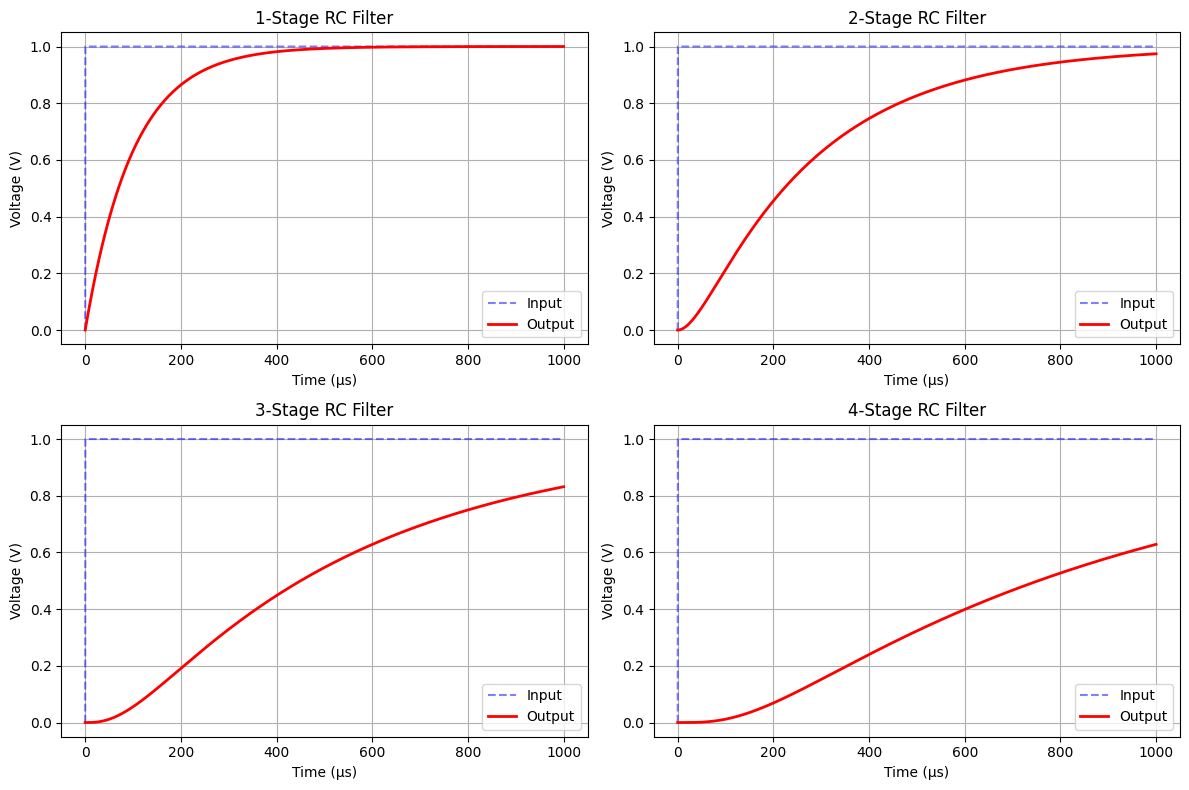

In [9]:
# Generate multi-stage RC filter netlist programmatically
def generate_rc_ladder(n_stages, R=1000, C=100e-9):
    lines = [f"* {n_stages}-Stage RC Ladder Filter"]
    lines.append("Vin in 0 1")
    
    for i in range(n_stages):
        node_in = "in" if i == 0 else f"n{i}"
        node_out = f"n{i+1}"
        lines.append(f"R{i+1} {node_in} {node_out} {R}")
        lines.append(f"C{i+1} {node_out} 0 {C}")
    
    lines.append(".end")
    return "\n".join(lines)

# Compare 1, 2, 3, 4 stage filters
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for idx, n_stages in enumerate([1, 2, 3, 4]):
    ax = axes[idx // 2, idx % 2]
    
    netlist = generate_rc_ladder(n_stages)
    ckt = ps.parse_netlist(netlist)
    
    x0 = np.zeros(ckt.system_size())
    times, states, success, msg = ps.run_transient(ckt, 0.0, 1e-3, 1e-7, x0)
    states = np.array(states)
    
    # Output is at last node (index = n_stages)
    ax.plot(np.array(times) * 1e6, states[:, 0], 'b--', alpha=0.5, label='Input')
    ax.plot(np.array(times) * 1e6, states[:, n_stages], 'r-', linewidth=2, label='Output')
    ax.set_xlabel('Time (µs)')
    ax.set_ylabel('Voltage (V)')
    ax.set_title(f'{n_stages}-Stage RC Filter')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Example: H-Bridge Motor Driver

In [10]:
hbridge_netlist = """
* H-Bridge Motor Driver
Vdc vcc 0 24

* High-side switches
S1 vcc out_a ON
S2 vcc out_b OFF

* Low-side switches  
S3 out_a 0 OFF
S4 out_b 0 ON

* Motor (modeled as RL load)
Rmotor out_a motor_mid 1
Lmotor motor_mid out_b 10m
.end
"""

result = ps.parse_netlist_verbose(hbridge_netlist)
print(f"Title: {result.title}")
print(f"Nodes: {list(result.node_map.keys())}")
print(f"Devices: {result.circuit.num_devices()}")

ckt = result.circuit

# DC analysis
opts = ps.NewtonOptions()
x0 = np.zeros(ckt.system_size())
dc = ps.solve_dc(ckt, x0, opts)

if dc.success():
    print(f"\nDC Operating Point:")
    print(f"  V(out_a) = {dc.solution[result.node_map['out_a']]:.2f} V")
    print(f"  V(out_b) = {dc.solution[result.node_map['out_b']]:.2f} V")
    print(f"  Motor voltage = {dc.solution[result.node_map['out_a']] - dc.solution[result.node_map['out_b']]:.2f} V")

Title: H-Bridge Motor Driver
Nodes: ['motor_mid', 'out_a', 'out_b', 'vcc']
Devices: 7

DC Operating Point:
  V(out_a) = 24.00 V
  V(out_b) = 0.00 V
  Motor voltage = 24.00 V


## 7. Error Handling

The parser provides helpful error messages with line numbers.

In [11]:
# Test error handling
print("Error handling examples:")
print("=" * 50)

# Missing value
try:
    ps.parse_netlist("R1 a b")
except ps.NetlistParseError as e:
    print(f"\n1. Missing value:")
    print(f"   {e}")

# Invalid value
try:
    ps.parse_netlist("R1 a b xyz")
except ps.NetlistParseError as e:
    print(f"\n2. Invalid value:")
    print(f"   {e}")

# Negative resistance
try:
    ps.parse_netlist("R1 a b -1k")
except ps.NetlistParseError as e:
    print(f"\n3. Negative resistance:")
    print(f"   {e}")

# Unknown directive (warning, not error)
result = ps.parse_netlist_verbose("""
V1 a 0 5
R1 a b 1k
.OPTIONS RELTOL=1e-4
.end
""")
print(f"\n4. Unknown directive (warning):")
for w in result.warnings:
    print(f"   {w}")

Error handling examples:

1. Missing value:
   Line 1: Resistor requires: Rname n1 n2 value
  >> R1 a b

2. Invalid value:
   Line 1: Cannot parse value: 'xyz'

3. Negative resistance:
   Line 1: Resistor value must be positive: -1000.0
  >> R1 a b -1k

4. Unknown directive (warning):
   Line 3: Unsupported directive: .OPTIONS


## Summary

### Parser Functions

| Function | Description |
|----------|-------------|
| `parse_netlist(str)` | Parse netlist string, return Circuit |
| `parse_netlist_verbose(str)` | Parse with details (title, warnings, models) |
| `parse_value(str)` | Parse value with engineering suffix |

### Supported Devices

| Prefix | Device | Format |
|--------|--------|--------|
| R | Resistor | `R1 n1 n2 value` |
| C | Capacitor | `C1 n1 n2 value [IC=v]` |
| L | Inductor | `L1 n1 n2 value [IC=i]` |
| V | Voltage Source | `V1 n+ n- value` |
| I | Current Source | `I1 n+ n- value` |
| D | Diode | `D1 anode cathode` |
| S | Switch | `S1 n1 n2 [ON\|OFF]` |
| M | MOSFET | `M1 d g s [model]` |
| Q | IGBT | `Q1 c g e [model]` |

### Engineering Suffixes

`f` (1e-15), `p` (1e-12), `n` (1e-9), `u` (1e-6), `m` (1e-3), `k` (1e3), `meg` (1e6), `g` (1e9)

**Back to:** [Power Losses](11_power_losses.ipynb) | **Next:** [Device Library](13_device_library.ipynb)